<a href="https://colab.research.google.com/github/pgeorgantopoulos/pinns/blob/main/pinn_vs_neuraloperator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PINN

In [30]:
import torch
import matplotlib.pyplot as plt

In [5]:
t = torch.linspace(0,10,100)
t.requires_grad = True

def dxdt(x):
    """
    dx/dt = f(t) = a x
    """
    return -.9*x

f = torch.nn.Sequential(torch.nn.Linear(in_features=1, out_features=10),
                        torch.nn.Sigmoid(),
                        torch.nn.Linear(in_features=10, out_features=1)
                        )

optimizer = torch.optim.SGD(f.parameters(), lr=.001)
keep_loss = torch.zeros(10)
for k in range(10):
    optimizer.zero_grad()
    loss = torch.tensor([0.])
    for t_i in t:
        f_i = f(t_i.unsqueeze(0))
        dxdt_i = torch.autograd.grad(f_i, t_i, create_graph=True)[0]
        loss += (dxdt(t_i.unsqueeze(0)) - dxdt_i)**2 + (f(t[0].unsqueeze(0)) - torch.tensor([1]))**2
    loss.backward()
    optimizer.step()
    keep_loss[k] = loss.item()


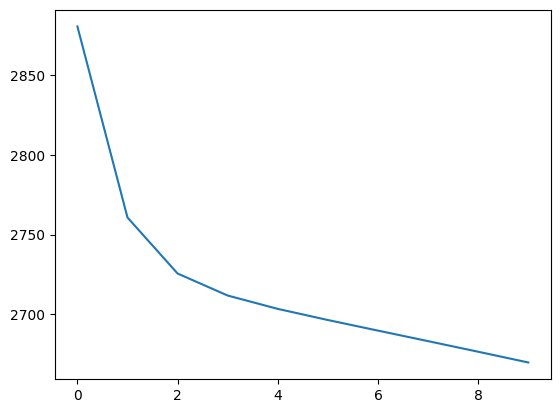

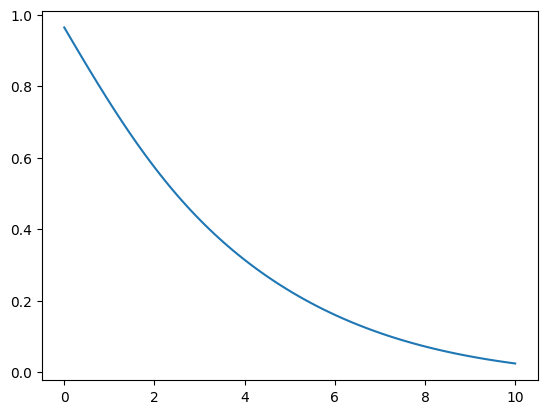

In [6]:
plt.plot(keep_loss)
plt.figure()
plt.plot(t.detach().numpy(), f(t.unsqueeze(1)).detach().numpy(), )

# Neural Operator

In [49]:
t = torch.linspace(0,1,10).cuda()
x0 = torch.randn(1,10).cuda()

def dxdt(t,x0):
  """
  dx/dt = f(t) = a x
  """
  return -.9*x

def x(t,x0):
  """
  x = e^{at} x_0
  """
  return torch.exp(-0.9*t.view(-1,1)) * x0

x_c = x(t,x0).cuda()

f = torch.nn.Sequential(torch.nn.Linear(in_features=1, out_features=100),
                        torch.nn.Tanh(),
                        torch.nn.Linear(in_features=100, out_features=10),
                        ).cuda()

optimizer = torch.optim.SGD(f.parameters(), lr=.01)
nepochs = 10000
keep_loss = torch.zeros(nepochs)
for k in range(nepochs):
  optimizer.zero_grad()
  loss = torch.tensor([0.])
  x_pred = f(x0.view(-1,1,1)).squeeze()
  loss = torch.nn.functional.mse_loss(x_pred, x_c)
  loss.backward()
  optimizer.step()
  keep_loss[k] = loss.item()

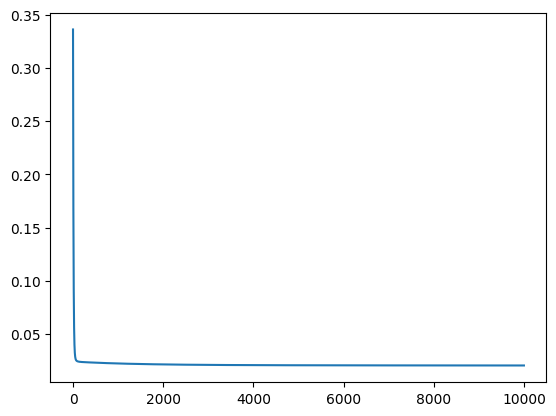

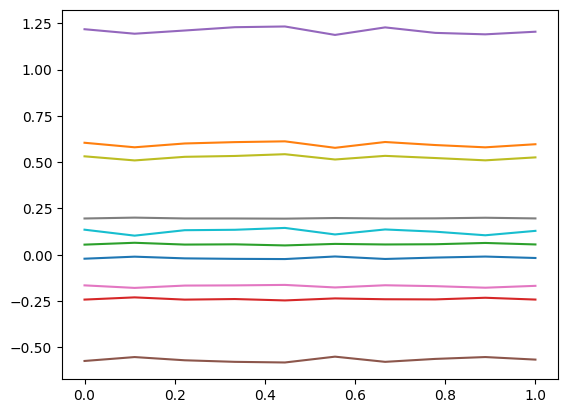

In [50]:
plt.plot(keep_loss)
plt.figure()
plt.plot(t.cpu().numpy(), f(x0.view(-1,1,1)).squeeze().cpu().detach().numpy())